In [1]:
import pandas as pd
import numpy as np
from simulator import conduct_simulation

# Experiments

# Input data processing
df = pd.read_table('iris.data', header=None)
raw_data = np.array(df)
pro_data = [[],[],[]]
for item in raw_data:
    pro_item = str(item[0]).split(',')
    pro_item = [eval(pro_item[0]),eval(pro_item[1]),eval(pro_item[2]),eval(pro_item[3]),pro_item[4]]
    if pro_item[4] == 'Iris-setosa':    
        pro_item[4] = 0
        pro_data[0].append(pro_item)
    if pro_item[4] == 'Iris-versicolor': 
        pro_item[4] = 1
        pro_data[1].append(pro_item)
    if pro_item[4] == 'Iris-virginica':  
        pro_item[4] = 2
        pro_data[2].append(pro_item)
pro_data = np.array(pro_data)

# Components for GMM model
components_num = 3

# Proportion of training and test sets
train_ratio_list = np.array([0.3,0.4,0.5,0.6,0.7,0.8,0.9])

# Monte Carlo experiments num
N = 1

# Simulation
mean_accuracy_classical, mean_accuracy_quantum_32, mean_accuracy_quantum_1024 = conduct_simulation(pro_data, train_ratio_list, components_num, N)


Train Ratio: 0.3
Iteration number: 0
Train Ratio: 0.4
Iteration number: 0
Train Ratio: 0.5
Iteration number: 0
Train Ratio: 0.6
Iteration number: 0
Train Ratio: 0.7
Iteration number: 0
Train Ratio: 0.8
Iteration number: 0
Train Ratio: 0.9
Iteration number: 0


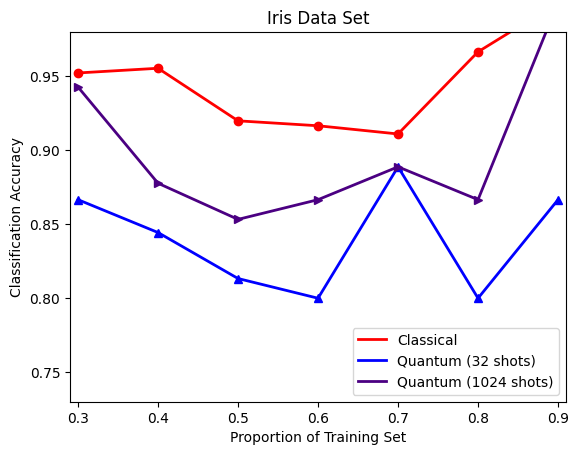

In [2]:
from plot_figure import plot_figure

# Plot
plot_figure("Iris Data Set", 0.73, 0.98, train_ratio_list, mean_accuracy_classical, mean_accuracy_quantum_32, mean_accuracy_quantum_1024)

In [16]:
mean_accuracy_quantum_32

array([0.81904762, 0.83333333, 0.86666667, 0.91666667, 0.77777778,
       0.96666667, 0.86666667])